In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

## User settings

In [2]:
N = 200 # number of nodes
L = 1 # domain length
dt = 0.0001 # time step
t0 = 0 # initial time instant

theta = 0 # for the selection of method in time

peclet = 150 # Peclet number
kappa = 0.1 # thermal diffusivity

tright = 1 # temperature at the end of the beam
tleft = 0 # temperature at the root of the beam

refresh_time = 5 # basically the inverse of the framerate, in MILLISECONDS

## Actual code

Mesh and stability check:

In [3]:
x = np.linspace(0, L, num=N)
dx = L/(N-1) # grid resolution
U = peclet/L*kappa # convection velocity
print() # new line
print('Local Peclet number: ', dx*U/kappa) # local Peclet number (stab. of stat. conv-diff)
print('Fourier number: ', kappa*dt/(dx**2)) # Fourier number (stab. of diffusion in time)
print('CFL number: ', dt*U/dx) # CFL umber (stab. of convection in time)
print() # new line


Local Peclet number:  0.3768844221105528
Fourier number:  0.39601000000000003
CFL number:  0.2985



Calculation of matrix B:

In [4]:
# calcolate coefficients depending on choice of scheme
#         convection     diffusion
BE =    - U / (2*dx)   + kappa/(dx**2)
BW =      U / (2*dx)   + kappa/(dx**2)
BP =          0        - 2*kappa/(dx**2)

# calculate matrix B discretising convection-diffusion
B = BW*np.diag(np.ones(N-1),-1) + BE*np.diag(np.ones(N-1),1) + BP*np.diag(np.ones(N))

# make B periodic: last row takes info from second point
B[-1, 1] = B[-2,-1]

Function to apply boundary conditions:

In [5]:
def apply_bc(M,v):
    # this takes a matrix and a vector and modifies first and last row
    # in order to account for boundary conditions

    # delete first row
    M[0,:] = 0

    # first row becomes:
    # first point = last point; Neumann like
    M[0,0] = 1
    M[0,-1] = -1
    v[0] = 0

    return M,v

Initial condition:

<IPython.core.display.Javascript object>


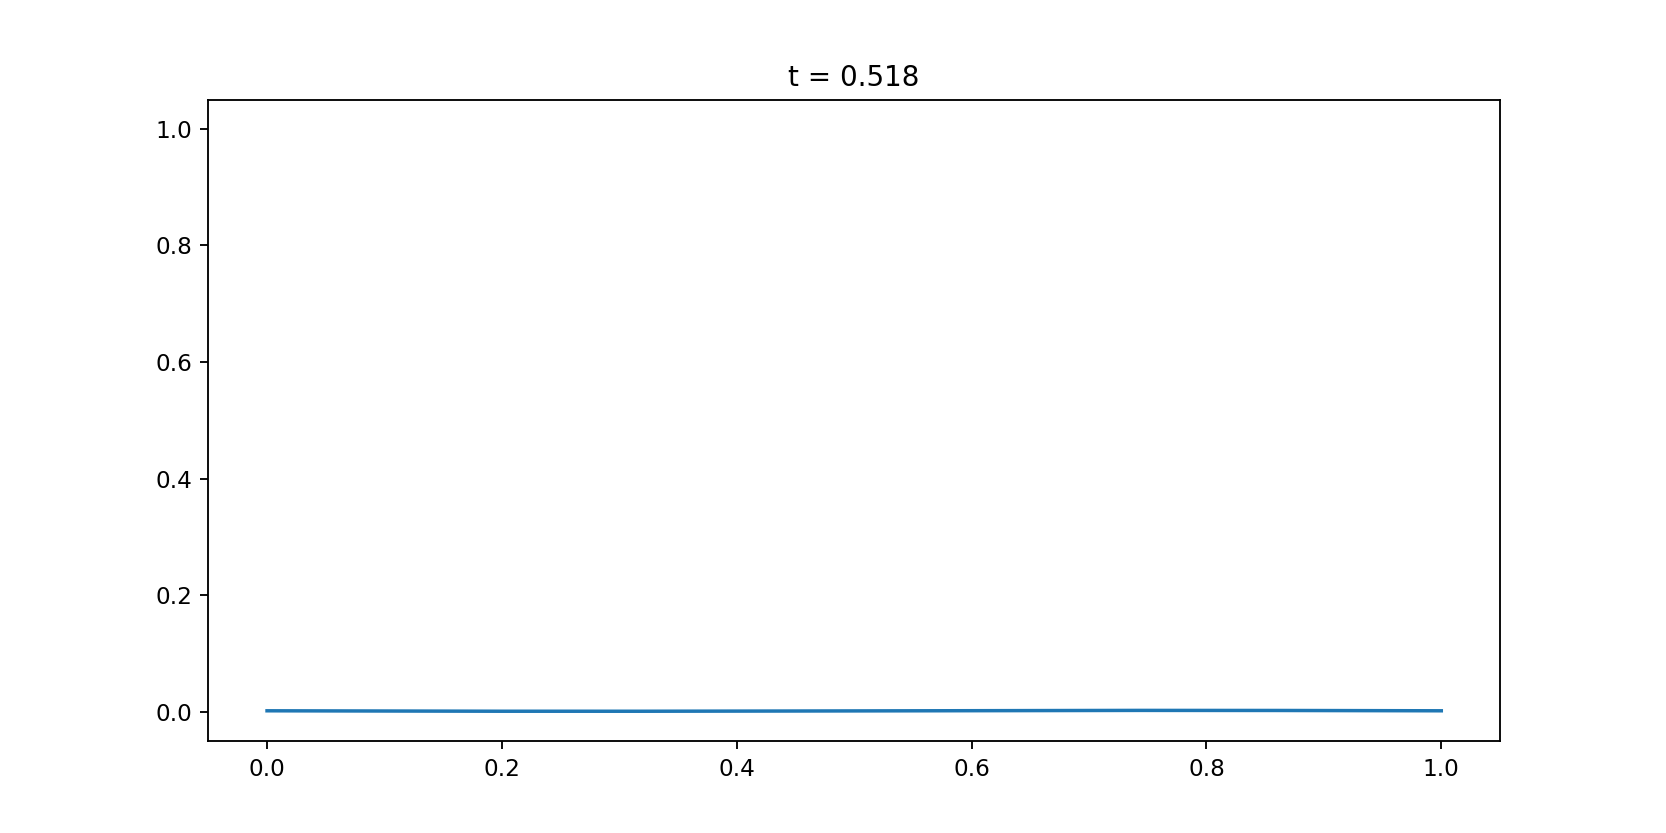

Text(0.5, 1.0, 't = 0')

In [6]:
t_curr = np.zeros_like(x) # temperature at current instant
t_curr[-1] = tright
t_curr[0] = t_curr[-1]
t_new = np.zeros_like(x) # temperature at next time step
b = np.zeros_like(x) # right hand side vector

# plot it
fig, ax = plt.subplots(figsize=(10,5))
solplot = ax.plot(x, t_curr) # update me!
ax.set_title('t = '+str(round(t0, 3))) # update me!

Matrices for time step:

In [7]:
# Matrix of coefficients (multiplies T_{n+1})
A = np.identity(N) - dt * theta * B

# Matrix that returns know term
E = np.identity(N) + dt * (1-theta) * B

# A * t_new = E * t_curr

Time step function:

In [8]:
def time_step(ii):

    global t_curr, t_new, b, A, E, t0

    # get known term and apply bc
    b[:] = E.dot(t_curr)
    A,b = apply_bc(A,b)

    # solve system
    t_new[:] = np.linalg.solve(A,b)

    # update
    t0 += dt
    buffer_pointer = t_curr
    t_curr = t_new
    t_new = buffer_pointer

    # plot
    solplot[0].set_ydata(t_curr)
    ax.set_title('t = '+str(round(t0, 3)))

    return solplot

Animate:

In [9]:
animation = FuncAnimation(fig, func=time_step, interval=refresh_time)
plt.show()